# Fine-tune RuBert

### Подготовка

In [1]:
# preload local libs
import sys
import os
import pathlib

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import trange

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Все доступные CUDA-устройства как список строк
def get_all_cuda_devices():
    devices = []
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            devices.append(f'cuda:{i}')
    else:
        devices.append('cpu')
    return devices

devices_list = get_all_cuda_devices()
print(f"Доступные устройства: {devices_list}")  # ['cuda:0', 'cuda:1', ...]

Доступные устройства: ['cuda:0']


In [5]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        # Получение свойств устройства
        props = torch.cuda.get_device_properties(i)
        
        print(f"Устройство {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Вычислительная способность: {props.major}.{props.minor}")
        print(f"  Общая память: {props.total_memory / 1024**3:.2f} GB")
        print(f"  Многопроцессорных блоков (SM): {props.multi_processor_count}")
else:
    print("CUDA недоступно")

Устройство 0: Tesla P100-PCIE-16GB
  Вычислительная способность: 6.0
  Общая память: 15.89 GB
  Многопроцессорных блоков (SM): 56


In [6]:
MODEL = 'DeepPavlov/rubert-base-cased'

BATCH_SIZE = 32

# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cuda:0' # Tesla P100 16 GB

### Загрузка данных

In [7]:
train_df = pd.read_csv(project_dir + "/hw-08/RuCoLA/data/in_domain_train.csv")
test_df  = pd.read_csv(project_dir + "/hw-08/RuCoLA/data/in_domain_dev.csv")

In [8]:
train_df

,id,sentence,acceptable,error_type,detailed_source
0,0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010
...,...,...,...,...,...
7864,7864,Установки не было введено в действие.,0,Semantics,Paducheva2004
7865,7865,"Конечно, против такой системы ценностей решите...",0,Semantics,Paducheva2013
7866,7866,Симптомов болезни не исчезло.,0,Semantics,Paducheva2013
7867,7867,Послезавтра температура у больного снижается д...,0,Semantics,Rusgram


In [9]:
train_df.acceptable.value_counts()

acceptable
1    5864
0    2005
Name: count, dtype: int64

Целевой параметр - `acceptable`. Разделение классов несбалансированое.

### Токенизатор

Используем токенизатор из модели

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

### Train, Test, Validation

In [11]:
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=1,
    stratify=train_df['acceptable']
)

# Так как дальше в Dataloader работаем с индексами строк, то после стратификации нужно пересобрать индексы
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

### Dataset и Dataloader

In [12]:
def encoding_func(text, max_length=256):
    return tokenizer(
        text,
        truncation=True,            # что делать, если текст длиннее. Если текст длиннее max_length, то обрезать его (по умолчанию с конца)
        padding="max_length",       # как выравнивать длину. Дополнять (паддить) все примеры в батче до длины max_length нулями (padding token)
        max_length=max_length,      # максимальная длина последовательности после токенизации (включая специальные токены)
        return_tensors="pt",        # в каком формате вернуть результат. Вернуть результат в формате PyTorch тензоров ("tf" - TensorFlow, "np" - numpy)
        add_special_tokens=True,    # добавлять [CLS], [SEP] и т.д.?
        return_attention_mask=True, # нужно ли возвращать attention mask. Добавить в результат словарь ключ attention_mask (1 = реальный токен, 0 = padding)
    )

In [13]:
class RuCoLADataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df['sentence'].tolist()
        self.labels = df['acceptable'].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = encoding_func(self.texts[idx])

        item = {k: v.squeeze(0) for k, v in encoding.items()}
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return item, label
    
train_dataset = RuCoLADataset(train_df, tokenizer)
val_dataset = RuCoLADataset(val_df, tokenizer)
test_dataset = RuCoLADataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Optimizer и Loss

Для интереса проведем оценку оптимизаторов для данной модели.

In [14]:
from torch import optim

# model.classifier.parameters()
criterion = nn.CrossEntropyLoss()

torch_optimizers = [
    (optim.SGD, 'SGD', {'lr': 5e-5}),
    (optim.SGD, 'Momentum', {'lr': 5e-5, 'momentum': 0.9}),
    (optim.SGD, 'Nesterov_Momentum', {'lr': 5e-5, 'momentum': 0.9, 'nesterov': True}),
    (optim.Adagrad, 'Adagrad', {'lr': 1e-6}),
    (optim.RMSprop, 'RMSprop', {'lr': 1e-6}),
    (optim.Adam, 'Adam', {'lr': 1e-5}),
    (optim.Adamax, 'Adamax', {'lr': 1e-5}),
    (optim.AdamW, 'AdamW', {'lr': 1e-5, 'weight_decay': 0.01}),
    (optim.NAdam, 'NAdam', {'lr': 1e-5})
    ]

### Training

In [15]:
def train_epoch(model, optimizer, loader):
    model.train()

    epoch_loss = 0
    for inputs, labels in loader:
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        labels = labels.to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def eval_epoch(model, loader):
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            labels = labels.to(DEVICE)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    mcc = matthews_corrcoef(all_labels, all_preds)
    
    return acc, f1, mcc


Для начала оценим обучим модели для разных оптимизаторов. Результаты сохраним, чтобы не повторять долгое обучение позже.\
Обучение производится на видеокарте с 16GB памяти.

In [ ]:
import time
import gc

EPOCHS = 20

for optim_cls, optim_name, optim_params in torch_optimizers:
    gc.collect()
    torch.cuda.empty_cache()

    print(f"Оптимизатор: {optim_name}")
    # Инициализация модели с нуля
    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2).to(DEVICE)
    # Оптимизатор
    optimizer = optim_cls(model.parameters(), **optim_params)
    opt_losses = []
    opt_metrics = []

    for epoch in trange(EPOCHS):
        train_loss = train_epoch(model, optimizer, train_loader)
        # time.sleep(10) # отдых карте
        val_acc, val_f1, val_mcc = eval_epoch(model, val_loader)

        print(f"Epoch {epoch+1}/{EPOCHS}")
        opt_losses.append(train_loss)
        opt_metrics.append({'acc': val_acc, 'f1': val_f1, 'mcc': val_mcc})
        time.sleep(10) # отдых карте

    torch.save(
        {
            'opt_name': optim_name,
            'model_state_dict': model.state_dict(),
            'opt_state_dict': optimizer.state_dict(),
            'epochs': EPOCHS,
            'losses': opt_losses,
            'metrics': opt_metrics
        },
        f'model_{optim_name}.pth'
        )

RuCoLa - небольшой по размеру датасет с несбалансированными классами.\
При обучении использовались оценки по метрикам F1 и MMC.

### Визуализация

In [17]:
plot_losses = {}
plot_f1 = {}
plot_mcc = {}

for optim_cls, optim_name, optim_params in torch_optimizers:
    pth = torch.load(
        f"model_{optim_name}.pth",
        map_location=torch.device("cpu"),      # иначе она забивает видеапамять
        weights_only=True,
        )
    pth_losses = pth['losses']
    pth_metrics = pth['metrics']
    pth_f1 = []
    pth_mcc = []

    for a, b in enumerate(pth_losses):
        epoch = a+1
        loss = b
        pth_f1.append(pth_metrics[a]['f1'])
        pth_mcc.append(pth_metrics[a]['mcc'])
        
    plot_losses[optim_name] = pth_losses
    plot_f1[optim_name] = pth_f1
    plot_mcc[optim_name] = pth_mcc

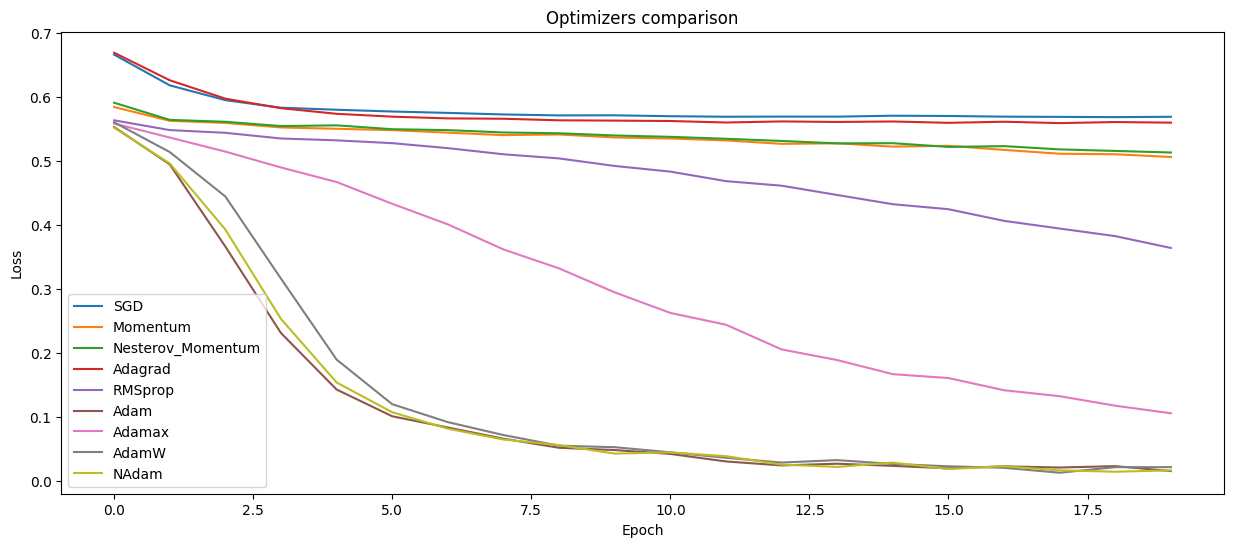

In [18]:
plt.figure(figsize=(15, 6))

for optim_name, pth_losses in plot_losses.items():
    plt.plot(range(len(pth_losses)), pth_losses, label=f'{optim_name}')

plt.title('Optimizers comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

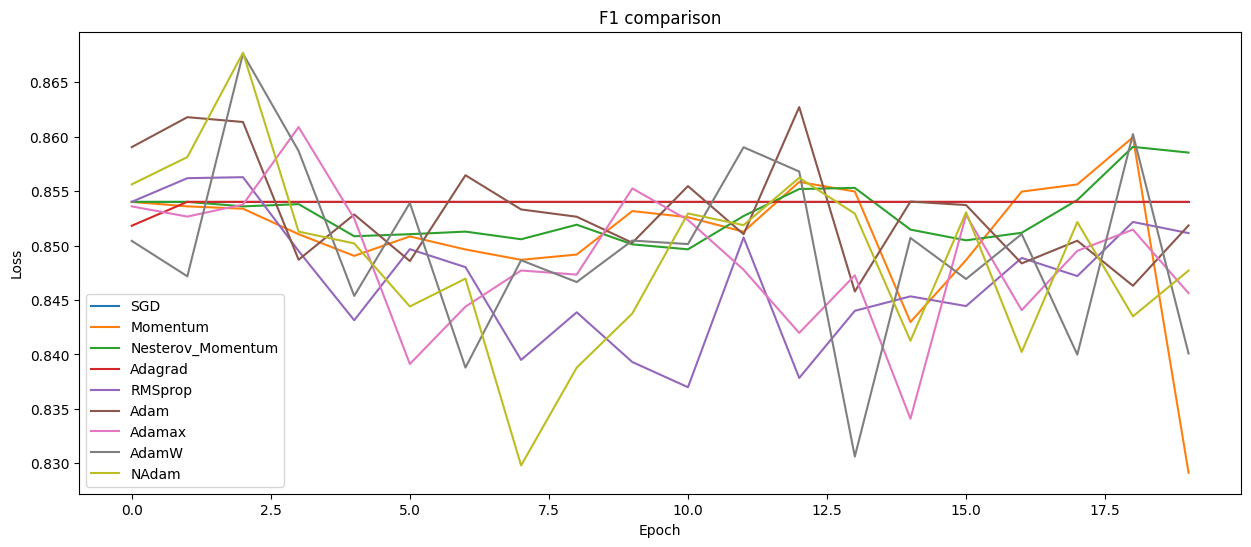

In [19]:
plt.figure(figsize=(15, 6))

for optim_name, pth_f1 in plot_f1.items():
    plt.plot(range(len(pth_f1)), pth_f1, label=f'{optim_name}')

plt.title('F1 comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

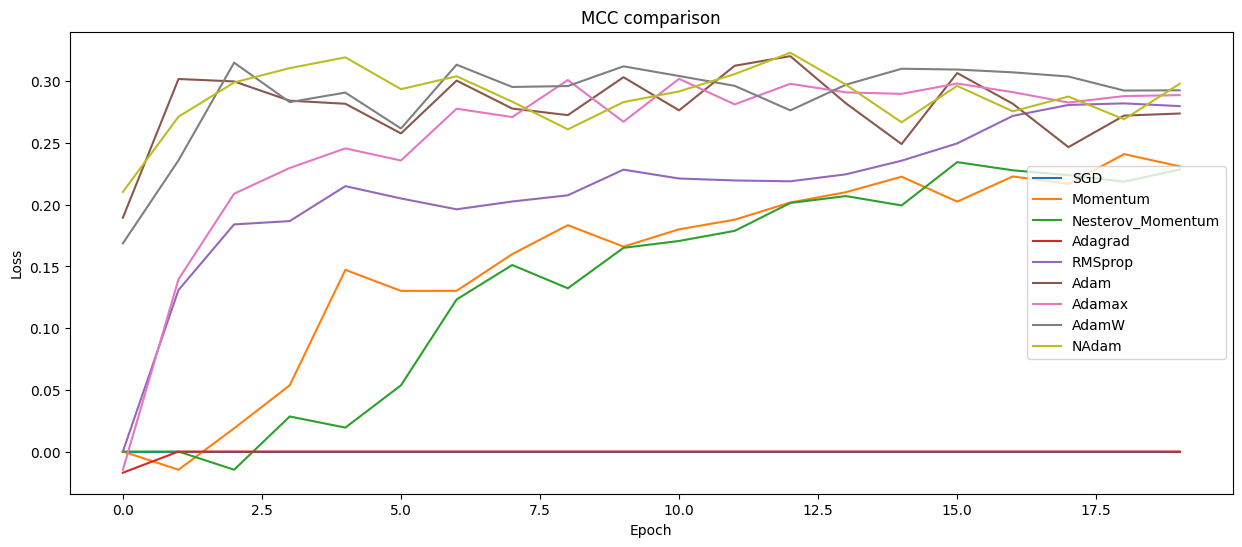

In [20]:
plt.figure(figsize=(15, 6))

for optim_name, pth_mcc in plot_mcc.items():
    plt.plot(range(len(pth_mcc)), pth_mcc, label=f'{optim_name}')

plt.title('MCC comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Тестирование

In [ ]:
results = []

for optim_cls, optim_name, optim_params in torch_optimizers:
    pth = torch.load(f"model_{optim_name}.pth", map_location=torch.device(DEVICE))
    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2).to(DEVICE)
    model.load_state_dict(pth['model_state_dict'])

    val_acc, val_f1, val_mcc = eval_epoch(model, test_loader)

    results.append({
            "optimizer": optim_name,
            "accuracy": val_acc,
            "f1": val_f1,
            "mcc": val_mcc
        })

pd.DataFrame(results)

In [22]:
pd.DataFrame(results)

,optimizer,accuracy,f1,mcc
0,SGD,0.745677,0.854312,0.000000
1,Momentum,0.756867,0.845107,0.294460
2,Nesterov_Momentum,0.772126,0.862913,0.280018
3,Adagrad,0.745677,0.854312,0.000000
4,RMSprop,0.787386,0.866964,0.369715
5,Adam,0.777213,0.860421,0.338097
6,Adamax,0.780264,0.859740,0.367043
7,AdamW,0.772126,0.853786,0.348583
8,NAdam,0.774161,0.856031,0.347321


**Выводы**

Быстрее всего ошибка обучения сокращалась у методов Adam*. При этом величина этой ошибки почти никак не сказывалась на качестве обучения по метрике F1, но зато показвала результат по метрике MCC.
Не зря MCC считается стандартом для BERT моделей.

В целом, значение метрики MCC около 0.3 не очень хороший результат. Лучше случайного угадывания, но далек от хорошего предсказывания. В целом, для обучения даже хватило бы 5-10 эпох, вместо 20.

Странные результаты показали оптимизаторы SDG и Adagrad

### Пример использования

In [26]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2).to(DEVICE)
model.load_state_dict(torch.load("model_AdamW.pth", map_location=torch.device(DEVICE))['model_state_dict'])
model.eval()

text = "Луна тоже нызенько-нызенько над горизонтом и густые синие предрассветные сумерки только начинают рассеиваться, постепенно превращаясь в торжествующий день, полный солнца, мороза и сверкающего алмазами снега и льда. Русская зима поет нам Песнь льда и солнца."
# text = "В заснеженном сквере под белым кустом Беседовал ангел с бездомным котом. Был вестник крылатый для прочих незрим, Общался с бродяжником точно с родным."
# text = "Как у нашего кота, случилась оказия и срочно ехать в Старую Москву понадобилось. А машина и не завелась, а ехать надобно шибко. Вот и познал котейка автобусный дзен."

inputs = encoding_func(text).to(DEVICE)
# print(inputs)

with torch.no_grad():
    outputs = model(**inputs)
    #print('LOG', outputs.logits)
    probs = torch.softmax(outputs.logits, dim=1)
    #print('PROBS', probs)
    pred = torch.argmax(probs, dim=1).item()
    #print('PRED', pred)

print("Prediction:", pred)
print("Probabilities:", probs.cpu().tolist())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction: 1
Probabilities: [[0.0007320947479456663, 0.9992678761482239]]


Смысл RuCoLA: предложение должно «звучать как нормальный русский», а не просто быть словосочетанием с правильными словами.\
Проверим, как этому научилась BERT-модель. Для проверки подам список некорректных выражений.

In [27]:
# Список составлен с помощью ChatGPT с комментариями
examples = [
    "Я яблоки купил вчера магазин в.",         # перестановка слов
    "Магазин я в пошёл.",                      # неправильный порядок слов
    "Вчера купил магазин яблоки я.",           # полный хаос
    "Я купил яблоки вчера магазин.",           # почти нормально, но порядок странный
    "Купить в магазин пошёл я яблоки вчера.",  # абсурдная грамматика
    "Я пошёл магизон яблоки купить.",          # выдуманное слово "магизон"
    "В магазин купил яблоки я вчера.",         # другой порядок
    "Я в яблоки магазин купил вчера.",         # хаотично, смешано
    "Я пошёл магазин в яблоки купить вчера.",  # странная последовательность
    "Магазин вчера я яблоки в купил."          # максимально абсурдно
]

In [28]:
def evaluate_sentence(model, sentence):
    model.eval()
    inputs = encoding_func(sentence).to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        p_acceptable = probs[0, 1].item()
        label = int(p_acceptable >= 0.5)

    return sentence, label, p_acceptable

for sent in examples:
    s, lbl, prob = evaluate_sentence(model, sent)
    print(f"{prob:.3f} | {'ACCEPTABLE' if lbl else 'UNACCEPTABLE'} | {s}")


0.999 | ACCEPTABLE | Я яблоки купил вчера магазин в.
0.993 | ACCEPTABLE | Магазин я в пошёл.
0.947 | ACCEPTABLE | Вчера купил магазин яблоки я.
0.996 | ACCEPTABLE | Я купил яблоки вчера магазин.
0.023 | UNACCEPTABLE | Купить в магазин пошёл я яблоки вчера.
0.448 | UNACCEPTABLE | Я пошёл магизон яблоки купить.
1.000 | ACCEPTABLE | В магазин купил яблоки я вчера.
1.000 | ACCEPTABLE | Я в яблоки магазин купил вчера.
0.628 | ACCEPTABLE | Я пошёл магазин в яблоки купить вчера.
0.911 | ACCEPTABLE | Магазин вчера я яблоки в купил.


**Выводы**

В этом наборе все фразы были некорректными, но модель это определила весьма посредственно.\
Возможно, что причина в ограниченных данных на обучении и вариативность примеров в этом тесте сильно отличается от данных в RuCoLa.